Loading and preprocessing data...
Reading CSV file...
Filtering invalid entries and removing label 4...

Class distribution before downsampling:
label_majority
1    3238
2    9753
3    2106
Name: count, dtype: int64

Downsampling only class 2 to 70.0% of its original size...

Class distribution after downsampling:
label_majority
1    3238
2    6827
3    2106
Name: count, dtype: int64

Calculating features...
All important features are present in the dataset.

Preparing features and target...
Splitting data...
Training model...

Training with 60 features:
1. num_solids
2. num_faces
3. num_edges
4. volume
5. surface_area
6. x_dim
7. y_dim
8. z_dim
9. num_line_edges
10. num_circle_edges
11. num_ellipse_edges
12. num_hyperbola_edges
13. num_parabola_edges
14. num_beziercurve_edges
15. num_bsplinecurve_edges
16. num_othercurve_edges
17. num_plane_surfaces
18. num_cylinder_surfaces
19. num_cone_surfaces
20. num_sphere_surfaces
21. num_torus_surfaces
22. num_bezier_surfaces
23. num_bspline_su

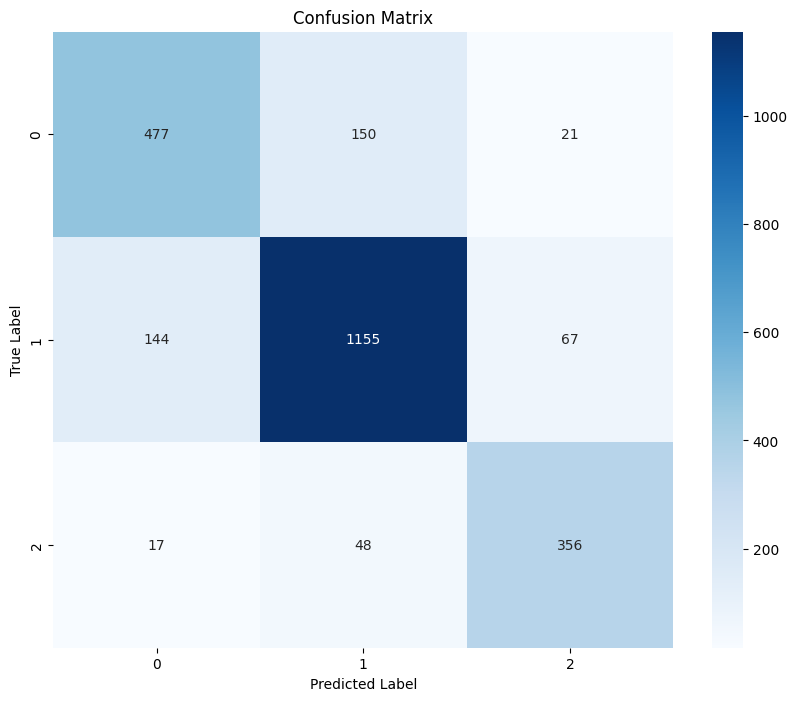


Model saved as: models/new_model_101.joblib
Scaler saved as: models/new_scaler_101.joblib
Selected features saved as: models/selected_features_101.joblib

Top 20 most important features:
                         Feature  Importance
38                  shape_factor    0.085678
36          thickness_complexity    0.080241
27                wall_thickness    0.053853
14        num_bsplinecurve_edges    0.033427
52                 volume_to_xyz    0.031898
42  num_bsplinecurve_edges_ratio    0.029119
48    num_bspline_surfaces_ratio    0.028144
49               aspect_ratio_xy    0.023305
59            overall_complexity    0.023135
1                      num_faces    0.022878
31       volume_to_surface_ratio    0.021638
39          num_line_edges_ratio    0.021222
37           average_edge_length    0.021095
58                 log_num_edges    0.020427
47      num_torus_surfaces_ratio    0.020045
50               aspect_ratio_xz    0.019086
22          num_bspline_surfaces    0.018890
51

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import os
import gc

def safe_divide(a, b):
    """Safely divide two pandas series or numpy arrays."""
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    return np.divide(a, b, out=np.zeros_like(a, dtype=np.float64), where=b!=0)

def calculate_features(data):
    """Calculate advanced geometric and topological features from the input data."""
    data = data.copy()
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].astype(np.float64)
    
    # Basic features
    features_to_calculate = [
        ('volume_to_surface_ratio', 'volume', 'surface_area'),
        ('edge_to_face_ratio', 'num_edges', 'num_faces'),
        ('average_face_area', 'surface_area', 'num_faces'),
        ('edge_complexity', 'num_edges', 'num_faces'),
        ('surface_complexity', 'num_unique_normals', 'num_faces'),
        ('thickness_complexity', 'wall_thickness', 'num_faces')
    ]
    
    for new_feat, num, denom in features_to_calculate:
        data[new_feat] = safe_divide(data[num].values, data[denom].values)
    
    # Edge length
    data['average_edge_length'] = safe_divide(
        data[['x_dim', 'y_dim', 'z_dim']].sum(axis=1).values,
        data['num_edges'].values
    )
    
    # Shape factor
    volume_pow = np.power(data['volume'].values, 2/3)
    data['shape_factor'] = safe_divide(data['surface_area'].values, volume_pow)
    
    # Ratios - Diese sind wichtig und müssen verwendet werden
    edge_columns = ['num_line_edges', 'num_circle_edges', 'num_ellipse_edges', 'num_bsplinecurve_edges']
    surface_columns = ['num_plane_surfaces', 'num_cylinder_surfaces', 'num_cone_surfaces', 
                    'num_sphere_surfaces', 'num_torus_surfaces', 'num_bspline_surfaces']
    
    # Edge ratios
    edge_total = data[edge_columns].sum(axis=1).values
    for col in edge_columns:
        data[f'{col}_ratio'] = safe_divide(data[col].values, edge_total)
    
    # Surface ratios
    surface_total = data[surface_columns].sum(axis=1).values
    for col in surface_columns:
        data[f'{col}_ratio'] = safe_divide(data[col].values, surface_total)
    
    # Aspect ratios - Geometrical features, die verwendet werden müssen
    data['aspect_ratio_xy'] = safe_divide(data['x_dim'].values, data['y_dim'].values)
    data['aspect_ratio_xz'] = safe_divide(data['x_dim'].values, data['z_dim'].values)
    data['aspect_ratio_yz'] = safe_divide(data['y_dim'].values, data['z_dim'].values)
    
    # Volume ratios
    xyz_product = data['x_dim'].values * data['y_dim'].values * data['z_dim'].values
    data['volume_to_xyz'] = safe_divide(data['volume'].values, xyz_product)
    data['surface_to_xyz'] = safe_divide(data['surface_area'].values, xyz_product)
    
    # Center mass distance
    center_cols = ['x_center_mass_relative', 'y_center_mass_relative', 'z_center_mass_relative']
    center_mass_coords = data[center_cols].values - 0.5
    data['center_mass_distance'] = np.linalg.norm(center_mass_coords, axis=1)
    
    # Log transforms - müssen verwendet werden
    for col in ['volume', 'surface_area', 'num_faces', 'num_edges']:
        min_positive = max(data[col].min(), 1e-10)
        data[f'log_{col}'] = np.log1p(data[col].clip(lower=min_positive))
    
    # Complexity score - wichtige Komplexitätsmaße
    complexity_cols = ['edge_complexity', 'surface_complexity', 'thickness_complexity']
    data['overall_complexity'] = data[complexity_cols].clip(lower=0).mean(axis=1)
    
    # Clean up
    data = data.replace([np.inf, -np.inf], 0).fillna(0)
    
    # Verify that important features are present
    important_features = [
        # Geometrical features
        'aspect_ratio_xy', 'aspect_ratio_xz', 'aspect_ratio_yz',
        # Complexity measures
        'edge_complexity', 'surface_complexity', 'thickness_complexity', 'overall_complexity',
        # Log transformations
        'log_volume', 'log_surface_area', 'log_num_faces', 'log_num_edges'
    ]
    
    # Add ratio features to the important list
    for col in edge_columns:
        important_features.append(f'{col}_ratio')
    for col in surface_columns:
        important_features.append(f'{col}_ratio')
    
    # Check if all important features are present
    missing_features = [f for f in important_features if f not in data.columns]
    if missing_features:
        print(f"WARNING: Missing important features: {missing_features}")
    else:
        print("All important features are present in the dataset.")
    
    return data

def load_and_preprocess_data(file_path, sample_size=None):
    """Load and preprocess the data with class-specific downsampling."""
    print("Reading CSV file...")
    data = pd.read_csv(file_path)
    
    print("Filtering invalid entries and removing label 4...")
    mask = (data['volume'] > 0) & (data['surface_area'] > 0) & (data['label_majority'] != 4)
    data = data[mask].copy()
    
    if 'filename' in data.columns:
        data = data.drop(columns=['filename'])
    
    print("\nClass distribution before downsampling:")
    print(data['label_majority'].value_counts().sort_index())
    
    if sample_size is not None and sample_size < 1.0:
        print(f"\nDownsampling only class 2 to {sample_size*100}% of its original size...")
        
        # Separate the dataset by class
        class1_data = data[data['label_majority'] == 1.0]
        class2_data = data[data['label_majority'] == 2.0]
        class3_data = data[data['label_majority'] == 3.0]
        
        # Only downsample class 2
        downsampled_class2 = class2_data.sample(frac=sample_size, random_state=42)
        
        # Recombine the datasets
        data = pd.concat([class1_data, downsampled_class2, class3_data], ignore_index=True)
        
        print("\nClass distribution after downsampling:")
        print(data['label_majority'].value_counts().sort_index())
    
    print("\nCalculating features...")
    data = calculate_features(data)
    
    return data

def train_model(X_train, y_train, random_state=42):
    """Train the model with custom SMOTE parameters."""
    n_samples = len(X_train)
    
    # Print information about the features used for training
    print(f"\nTraining with {X_train.shape[1]} features:")
    for i, feature in enumerate(X_train.columns, 1):
        print(f"{i}. {feature}")
    
    # Adjust k_neighbors based on class sizes
    k_neighbors = min(5, n_samples // 100)
    
    pipeline = imbPipeline([
        ('scaler', StandardScaler()),
        ('smotetomek', SMOTETomek(
            sampling_strategy='auto',
            smote=SMOTE(k_neighbors=k_neighbors, random_state=random_state),
            random_state=random_state
        )),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            random_state=random_state,
            n_jobs=-1  # Use all cores
        ))
    ])
    
    pipeline.fit(X_train, y_train)
    return pipeline

def save_model_components(pipeline, le, X_train, version="11"):
    """
    Save the trained model components separately with specified version number:
    - Random Forest model
    - Scaler
    - Selected features
    """
    # Create directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Extract components from pipeline
    rf_model = pipeline.named_steps['classifier']
    scaler = pipeline.named_steps['scaler']
    
    # Get feature names
    selected_features = list(X_train.columns)
    
    # Prepare filenames with specified version
    model_filename = f'models/new_model_{version}.joblib'
    scaler_filename = f'models/new_scaler_{version}.joblib'
    features_filename = f'models/selected_features_{version}.joblib'
    
    # Save components
    joblib.dump(rf_model, model_filename)
    joblib.dump(scaler, scaler_filename)
    joblib.dump(selected_features, features_filename)
    
    print(f"\nModel saved as: {model_filename}")
    print(f"Scaler saved as: {scaler_filename}")
    print(f"Selected features saved as: {features_filename}")
    
    # Feature importance analysis
    feature_importances = rf_model.feature_importances_
    features_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 20 most important features:")
    print(features_df.head(20))

def main():
    # Set your file path here
    file_path = r"C:\Users\meh91075\Downloads\features_newWallthickness_16092024.csv"
    
    # Optional: Use a smaller sample size for development/testing
    # Set to None or 1.0 to use full dataset
    SAMPLE_SIZE = 0.7  # Use 50% of data (only for class 2)
    
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data(file_path, sample_size=SAMPLE_SIZE)
    
    print("\nPreparing features and target...")
    X = df.drop(columns=['label_majority'])
    y = df['label_majority']
    
    # Clean up memory
    del df
    gc.collect()
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Clean up memory
    del X
    gc.collect()
    
    print("Training model...")
    pipeline = train_model(X_train, y_train)
    
    print("Making predictions...")
    y_pred = pipeline.predict(X_test)
    
    y_test_original = le.inverse_transform(y_test)
    y_pred_original = le.inverse_transform(y_pred)
    
    print("\nClassification Report:")
    print(classification_report(y_test_original, y_pred_original))
    
    cm = confusion_matrix(y_test_original, y_pred_original)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Save model components separately with version number
    save_model_components(pipeline, le, X_train, version="101")

if __name__ == "__main__":
    main()